<a href="https://colab.research.google.com/github/MarioSigal/Elementos-de-Reconocimiento-Visual/blob/main/Tareas/Tarea1_Categorizacion_Objetos_DFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Nombre del Grupo*: Nosotres

*Integrantes*: Lautaro masetto, Matias Halperin, Leonardo Dominguez, Mario Sigal Aguirre

#**Tarea 1: Categorizacion de Objetos usando Descriptores de Fourier**

La idea de esta tarea sera categorizar objetos del dataset [MPEG-7 CE-Shape-1 Part B dataset](https://dabi.temple.edu/external/shape/MPEG7/dataset.html) utilizando descriptores de Fourier y un KNN. Para experimentar usaremos una version reducida del dataset que pueden encontrar en este [link](https://drive.google.com/drive/folders/1U96YoNhmC6HANzYDOChVF98AIbIxbNiI?usp=sharing)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import gc
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.measure import find_contours
from skimage.transform import rotate, rescale
import re
from skimage.feature import canny
from skimage.util import img_as_ubyte
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## **Descriptor**

In [ ]:
def get_fourier_descriptors(image, num_descriptors=30):
    """
    Calcula los Descriptores de Fourier de Contornos (DFC) a partir de una imagen binaria,
    asegurando la invariancia a traslación, escala y rotación.
    """
    # Extraer contorno
    contours = find_contours(image, level=0.5)

    if not contours:
        return np.array([0.0] * num_descriptors)

    # Seleccionamos el contorno más largo
    contour = max(contours, key=len)

    x = contour[:, 1]
    y = contour[:, 0]
    complex_contour = x + 1j * y

    F = np.fft.fft(complex_contour)

    # normalizamos
    F[0] = 0
    F = F / np.abs(F[1])
    F = np.abs(F)

    # truncamos a K descriptores
    K_disponibles = len(F) - 1

    #Si tenemos más o igual descriptores lo truncamos
    if K_disponibles >= num_descriptors:
        descriptores = F[1:num_descriptors+1]

    #Sino, rellenamos con 0 los descriptores que faltan
    else:
        descriptores = np.zeros(num_descriptors)
        descriptores[:K_disponibles] = F[1:K_disponibles+1]

    return descriptores

## **Configuración y Carga del Dataset**


In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

# ⚠️ MODIFICA ESTA RUTA a como lo hayan guardado
DATASET_PATH = '/content/drive/MyDrive/dataset_shapes_reducido'

if not os.path.exists(DATASET_PATH):
    print(f"ERROR: La ruta del dataset no existe: {DATASET_PATH}. Por favor, créala y sube tus imágenes.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Función de Preprocesamiento y Extracción (Usando Canny)**

Implementar el preprocesamiento para imágenes reales usando Canny para detectar los bordes del contorno y luego extraer el descriptor.

In [ ]:
def process_and_extract_dfc_canny(file_path, K_features):
    """Carga la imagen, aplica el detector Canny, y extrae los DFCs."""
    try:
        # Cargar y convertir a escala de grises
        img = imread(file_path)[0]
        if len(img.shape) == 3:
          img = rgb2gray(img)

        # Detección de Bordes con Canny
        bordes = canny(img, sigma=1.0)

        # Convertir a array binario de enteros (0 o 1)
        bordes_binzarizado = bordes.astype(np.uint8)

        # Extraer DFCs
        descriptores = get_fourier_descriptors(bordes_binzarizado, K_features)

        return descriptores

    except Exception as e:
        print(f"Error al procesar {file_path}: {e}")
        return None

## **Creación del Dataset de Features y Clasificación**

Recorremos las imágenes de las carpetas de clases, extraemos los DFCs y entrenamos el KNN.

In [ ]:
# Parámetros
K_FEATURES_REAL = 30 # DFCs a usar

X_real = []
y_real = []
class_names = []
class_to_idx = {} # Mapeo de nombre de clase a índice (0, 1, 2, ...)
next_idx = 0

print("Comenzando el procesamiento de archivos GIF...")

# Iterar sobre los archivos en la única carpeta
for filename in os.listdir(DATASET_PATH):

    # Aseguramos que solo procesamos archivos GIF y que cumplen el patrón
    if filename.endswith('.gif'):

        # PARSEAR LA CLASE DEL NOMBRE DE ARCHIVO
        # El patrón es: nombre_de_clase-numero.gif
        match = re.match(r'(.+)-\d+\.gif$', filename)

        if match:
            class_name = match.group(1) # Extrae la parte antes del primer guion

            # Asignar un índice numérico a cada nombre de clase nuevo
            if class_name not in class_to_idx:
                class_to_idx[class_name] = next_idx
                class_names.append(class_name)
                next_idx += 1

            class_idx = class_to_idx[class_name]
            file_path = os.path.join(DATASET_PATH, filename)

            # ROCESAMIENTO Y EXTRACCIÓN DE DFC
            dfc_vector = process_and_extract_dfc_canny(file_path, K_FEATURES_REAL)
            if dfc_vector is not None and dfc_vector.size == K_FEATURES_REAL:
                X_real.append(dfc_vector)
                y_real.append(class_idx)

X_real = np.array(X_real)
y_real = np.array(y_real)
print("\n" + "="*50)
print(f"Resumen del Dataset: {X_real.shape[0]} muestras, {len(class_names)} clases.")
print("="*50)



Comenzando el procesamiento de archivos GIF...

Resumen del Dataset: 200 muestras, 10 clases.


## **Evaluacion**


RESULTADOS DE CLASIFICACIÓN (DFC + KNN)
Precisión (Accuracy) del clasificador KNN: 25.00%


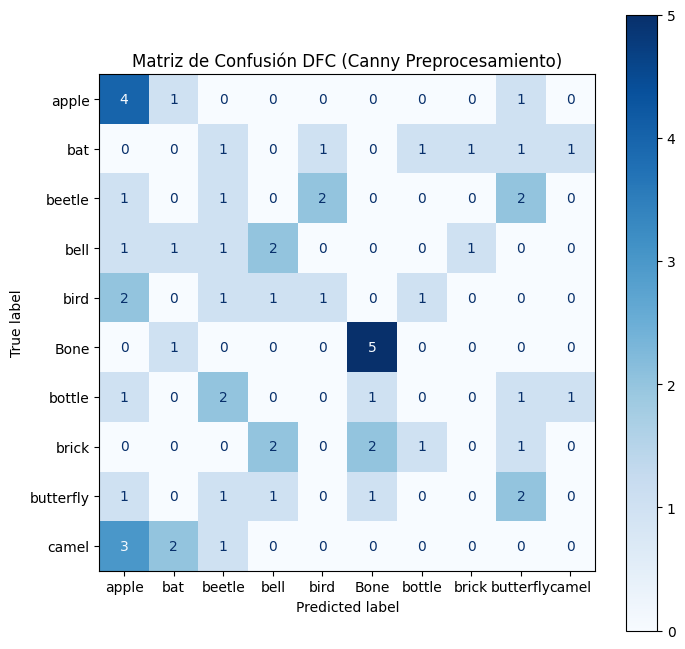

In [ ]:
if X_real.shape[0] > 10 and len(class_names) > 1:

    # Dividir el dataset (manteniendo la proporción de clases con stratify)
    X_train, X_test, y_train, y_test = train_test_split(
        X_real, y_real, test_size=0.3, random_state=42, stratify=y_real
    )

    # Entrenar el clasificador KNN
    knn_final = KNeighborsClassifier(n_neighbors=5)
    knn_final.fit(X_train, y_train)

    # Predecir y evaluar
    y_pred = knn_final.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("\n" + "="*50)
    print("RESULTADOS DE CLASIFICACIÓN (DFC + KNN)")
    print(f"Precisión (Accuracy) del clasificador KNN: {accuracy * 100:.2f}%")
    print("="*50)

    # Visualización de la Matriz de Confusión
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión DFC (Canny Preprocesamiento)')
    plt.show()

else:
    print("\nNo hay suficientes muestras (min. 11) o clases (min. 2) para realizar la clasificación.")

## ***Consigna***

**Consigna 1**: Impacto del Número de Descriptores (K) en la Performance

El número de descriptores KFEATURES_REAL​ que utilizas es crucial para la clasificación.

     

1.   ***Exploración de K***: Pruebren la clasificación del dataset con al menos cautro valores distintos para KFEATURES_REAL​ (por ejemplo, K=5, K=10, K=30, K=60). Registren el Accuracy obtenido en cada caso y plooteenlo.

2.   **Análisis Físico**: Expliquen por qué el accuracy se estabiliza o cae a partir de un cierto K. Relacionen esto con la naturaleza de los DFCs (bajas vs. altas frecuencias) y la calidad de los contornos extraídos con el detector Canny.


**Consigna 2**: Análisis de la Confusión y Desafíos del Dataset

Analicen la matriz de confusión y la precisión obtenida para el valor de K que dio el mejor resultado:

1. ***Identificación de Confusión***: ¿Qué par o pares de clases muestran la mayor confusión (más errores de predicción) en la matriz de confusión?

2. ***Causa de la Confusión***: Expliquen las razones morfológicas o de feature por las que estas clases se confunden. Consideren:

  * Similitud de Forma: ¿Son las siluetas de estas clases realmente muy parecidas?

  * Ruido del Contorno: ¿El ruido introducido por la binarización (Canny) y la truncación de los DFCs hace que las formas se vuelvan indistinguibles?

***Consigna 3***: Demuestra la invarianza: Escogan dos imágenes de la misma clase que sean muy diferentes en escala o rotación. Calculen la distancia euclidiana entre sus vectores DFC normalizados y comparen con la distancia entre dos imágenes de clases diferentes.

## ***Consigna 1***




### Funciones

In [ ]:
def process_dataset_and_extract_dfc(dataset_path, k_features):

  features = []
  labels = []
  image_paths = []
  class_names = []
  class_to_idx = {}
  next_idx = 0

  # Iteraramos sobre los archivos en la única carpeta
  for filename in os.listdir(dataset_path):

      # Nos Aseguramos que solo procesamos archivos GIF y que cumplen el patrón
      if filename.endswith('.gif'):

        # PARSEAR LA CLASE DEL NOMBRE DE ARCHIVO
        # El patrón es: nombre_de_clase-numero.gif
        match = re.match(r'(.+)-\d+\.gif$', filename)

        if match:
          class_name = match.group(1) # Extrae la parte antes del primer guion

          # Asignar un índice numérico a cada nombre de clase nuevo
          if class_name not in class_to_idx:
            class_to_idx[class_name] = next_idx
            class_names.append(class_name)
            next_idx += 1

          class_idx = class_to_idx[class_name]
          file_path = os.path.join(dataset_path, filename)

          # PROCESAMIENTO Y EXTRACCIÓN DE DFC
          feature_vector = process_and_extract_dfc_canny(file_path, k_features)
          if feature_vector is not None:
            features.append(feature_vector)
            labels.append(class_idx)
            image_paths.append(file_path)

  features = np.array(features)
  labels = np.array(labels)
  image_paths = np.array(image_paths)

  return features, labels, class_names, class_to_idx, image_paths

In [ ]:
def train_and_evaluate_knn(features, labels, class_names,seed):

  if features.shape[0] > 10 and len(class_names) > 1:

      # Dividir el dataset (manteniendo la proporción de clases con stratify)
      X_train, X_test, y_train, y_test = train_test_split(
          features, labels, test_size=0.3, random_state=seed, stratify=labels
      )

      # Entrenar el clasificador KNN
      knn_classifier = KNeighborsClassifier(n_neighbors=5)
      knn_classifier.fit(X_train, y_train)

      # Predecir y evaluar
      predictions = knn_classifier.predict(X_test)
      accuracy = accuracy_score(y_test, predictions)


  return knn_classifier, accuracy, predictions, X_test

In [ ]:
def evaluate_multiple_knn_global(dataset_path, k_features_list,seeds):
    all_accuracies = []

    for k_features in k_features_list:
        accuracies_for_k = []
        features, labels, class_names, class_to_idx, _ = process_dataset_and_extract_dfc(dataset_path, k_features)

        for seed in seeds:
            knn_model, accuracy, predictions, test_features = train_and_evaluate_knn(features, labels, class_names, seed=seed)
            accuracies_for_k.append(accuracy)

        mean_accuracy = np.mean(accuracies_for_k)
        all_accuracies.append(mean_accuracy)

    return all_accuracies

In [ ]:
def plot_accuracies(k_features, accuracies):
  plt.figure(figsize=(10, 6))
  plt.plot(k_features, accuracies, marker='o', linestyle='-', color='b')
  plt.title('Precisión promedio del Clasificador KNN en función de la cantidad de Descriptores')
  plt.xlabel('Cantidad de descriptores')
  plt.ylabel('Precisión promediada')
  plt.grid(True)
  plt.show()

### Resultados

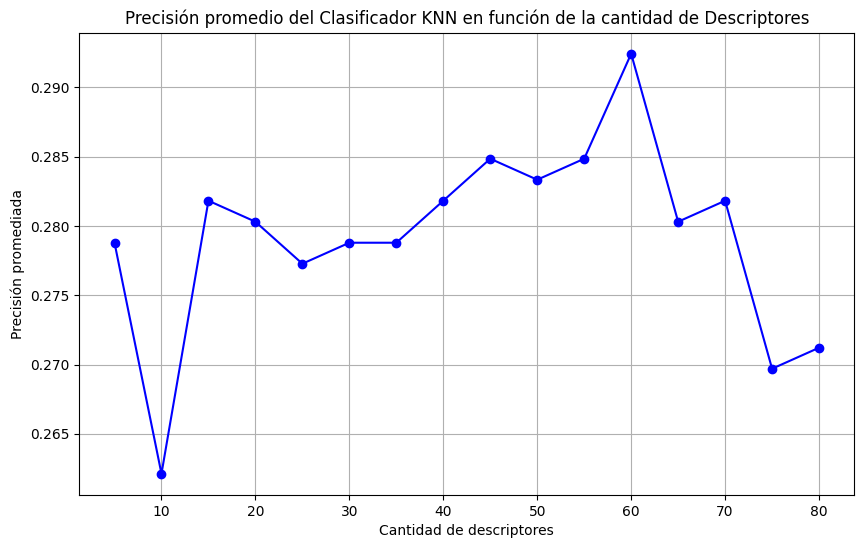

In [ ]:
k_values = list(range(5,81,5))
seeds = list(range(0,51,5))
acurracies = evaluate_multiple_knn_global(DATASET_PATH, k_values, seeds)
plot_accuracies(k_values, acurracies)

**Análisis Físico: Expliquen por qué el accuracy se estabiliza o cae a partir de un cierto K. Relacionen esto con la naturaleza de los DFCs (bajas vs. altas frecuencias) y la calidad de los contornos extraídos con el detector Canny.**

Como vemos en el gráfico anterior, al realizar un análisis global sobre varias seeds, la precisión tiende a subir y bajar según la cantidad de descriptores de Fourier utilizados.

Al princpio, con pocos descriptores de Fourier, vemos que la precisión es baja.Esto sucede debido a que las bajas frecuencias corresponden al contorno general de la figura. Por lo tanto, figuras con un contorno parecido se van a parecer más como un escarabajo y una campana, por ejemplo.

Luego, a medida que suben la cantidad de descriptores, va a tender a aumentar la precisión ya que las frecuencias intermedias capturan detalles importantes del contorno.Por ejemplo, con 60 descriptores podría diferenciar bien una manzana de un escarabajo porque tiene la informacion suficiente sobre la estructura de la figura.

Por último, cuanto más descriptores hay, la precisión va a tender a disminuir. Esto sucede porque va a ver con mejor detalle, pero como se realizo un canny previo, entonces los descriptores de alta frecuencia van a depender en gran medida de este último algoritmo, el cual puede introducir ruido. De esta forma, este "exceso en detalle" puede provocar sobreajuste y, en algunos casos, confundir imágenes de la misma clase.


## ***Consigna 2***

### Funciones

In [ ]:
def evaluate_knn_with_different_seeds(dataset_path, k_features, seeds_range):

    results_for_seed = {
        "seeds": [],
        "accuracy": []
    }
    features, labels, class_names, class_mapping, _ = process_dataset_and_extract_dfc(dataset_path, k_features)

    for seed in seeds_range:
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=seed, stratify=labels)
        knn_classifier = KNeighborsClassifier(n_neighbors=5)
        knn_classifier.fit(X_train, y_train)

        predictions = knn_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)

        results_for_seed["seeds"].append(seed)
        results_for_seed["accuracy"].append(accuracy)

    return results_for_seed


In [ ]:
results = evaluate_knn_with_different_seeds(DATASET_PATH, k_features=60, seeds_range=range(1, 101))
best_accuracy = max(results["accuracy"])
best_seed_index = results["accuracy"].index(best_accuracy)
best_seed = results["seeds"][best_seed_index]

print(f"La semilla con mejor precisión con 60 descriptores es {best_seed} con una precisión de {best_accuracy}")

La semilla con mejor precisión con 60 descriptores es 5 con una precisión de 0.4


In [ ]:
def plot_confusion_matrix_for_seed_and_features(dataset_path, features, seed):
    features, labels, class_names, class_mapping, _ = process_dataset_and_extract_dfc(dataset_path, features)
    if features.shape[0] > 10 and len(class_names) > 1:

        # Dividir el dataset (manteniendo la proporción de clases con stratify)
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=seed, stratify=labels)

        # Entrenar el clasificador KNN
        knn_classifier = KNeighborsClassifier(n_neighbors=3)
        knn_classifier.fit(X_train, y_train)

        # Predecir y evaluar
        predictions = knn_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)

        print("\n" + "="*50)
        print("RESULTADOS DE CLASIFICACIÓN (DFC + KNN)")
        print(f"Precisión (Accuracy) del clasificador KNN: {accuracy * 100:.2f}%")
        print("="*50)

        # Visualización de la Matriz de Confusión
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title('Matriz de Confusión DFC (Canny Preprocesamiento)')
        plt.show()
    else:
        print("\nNo hay suficientes muestras (min. 11) o clases (min. 2) para realizar la clasificación.")




In [ ]:
def plot_confusion_matrix_for_seed_and_features(dataset_path, features, seed, target_classes_list):
    features, labels, class_names, class_mapping, image_paths = process_dataset_and_extract_dfc(dataset_path, features)

    if features.shape[0] > 10 and len(class_names) > 1:
        X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
            features, labels, image_paths, test_size=0.3, random_state=seed, stratify=labels
        )

        knn_classifier = KNeighborsClassifier(n_neighbors=5)
        knn_classifier.fit(X_train, y_train)

        predictions = knn_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)

        #Tomamos aquellas imagenes que aparecen en la matriz de confusión y que aparezcan en la lista target_classes_list
        misclassified_images_indices = [index for index, (true_label, predicted_label) in enumerate(zip(y_test, predictions)) if true_label != predicted_label and
           (class_names[true_label] in target_classes_list)]

        n_images = len(misclassified_images_indices)

        if misclassified_images_indices:
            n_rows = (n_images + 1) // 2
            plt.figure(figsize=(8, 3 * n_rows))
            for j, idx in enumerate(misclassified_images_indices):
                #Dibujamos 2 imagenes por fila
                plt.subplot(n_rows, 2, j + 1)

                #Recuperamos la imagen original
                img = imread(paths_test[idx])

                #Eliminamos las dimensiones de tamaño 1 para pasar a un vector de 3
                img = np.squeeze(img)

                #Pasamos a gris
                if img.ndim == 3:
                    if img.shape[2] == 4:
                        img = img[:, :, :3]
                    img = rgb2gray(img)

                bordes = canny(img, sigma=1.0)

                bordes_binzarizado = bordes.astype(np.uint8)

                plt.imshow(bordes_binzarizado, cmap='gray')
                plt.title(f"clase verdadera: {class_names[y_test[idx]]}\n clase predicha: {class_names[predictions[idx]]}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()

    else:
        print("\nNo hay suficientes muestras (min. 11) o clases (min. 2) para realizar la clasificación.")



### Resultados


RESULTADOS DE CLASIFICACIÓN (DFC + KNN)
Precisión (Accuracy) del clasificador KNN: 43.33%


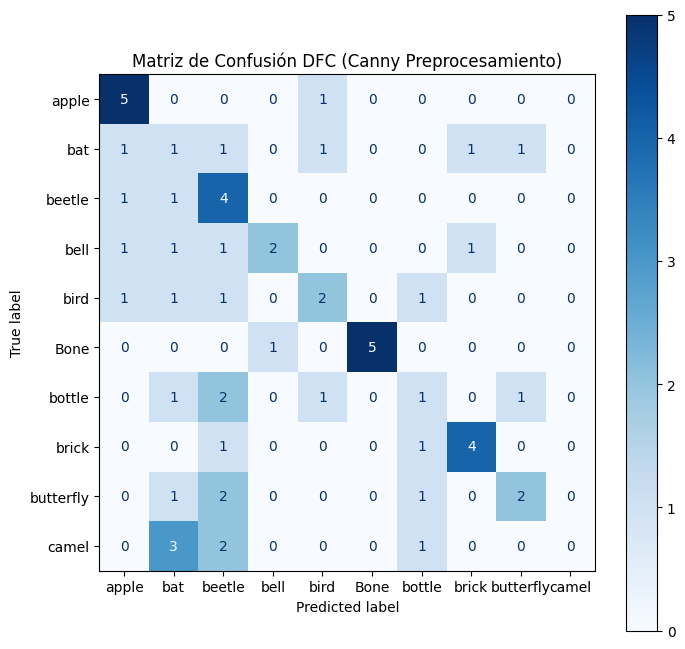

In [ ]:
plot_confusion_matrix_for_seed_and_features(DATASET_PATH, 60, best_seed)

Vemos que las clases que más se confunden son botella, camello y murcielago. En donde, en particular, no acertó ningún camello

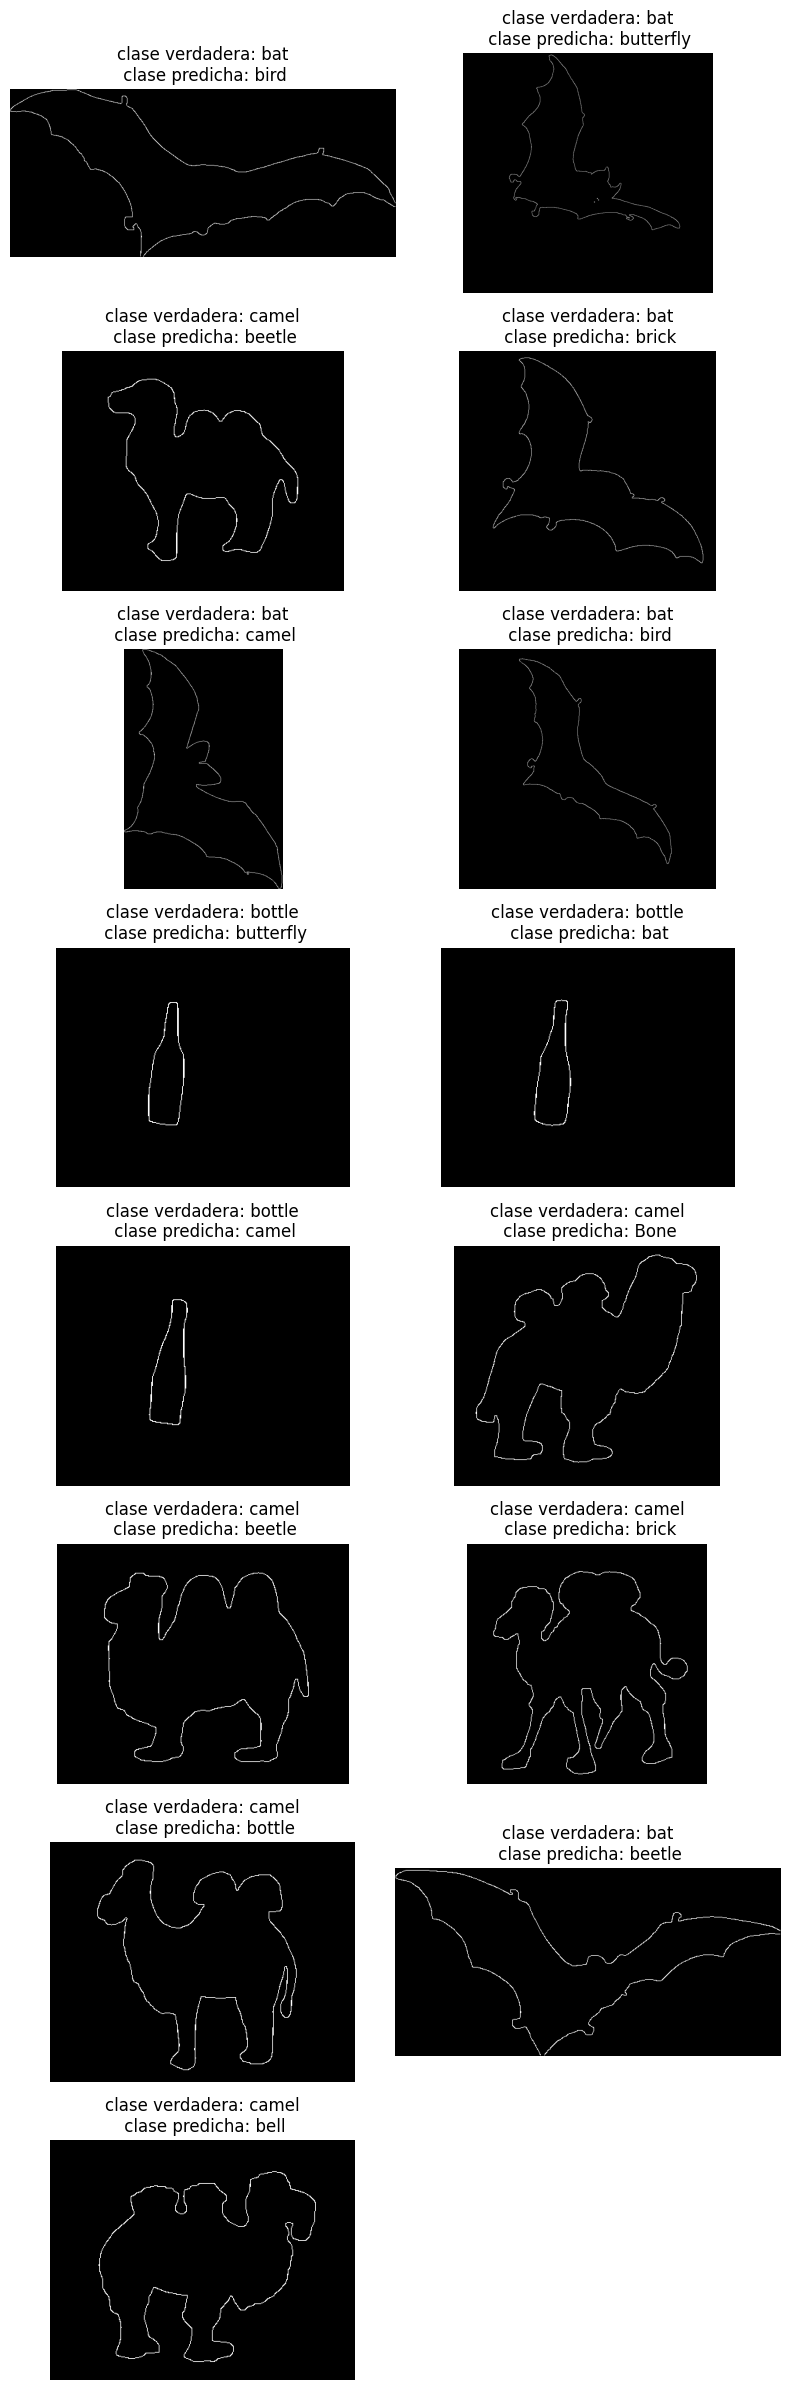

In [ ]:
plot_confusion_matrix_for_seed_and_features(DATASET_PATH, 60, best_seed, ["camel","bottle", "bat"])

Analicen la matriz de confusión y la precisión obtenida para el valor de K que dio el mejor resultado:

1. ***Identificación de Confusión***: ¿Qué par o pares de clases muestran la mayor confusión (más errores de predicción) en la matriz de confusión?

2. ***Causa de la Confusión***: Expliquen las razones morfológicas o de feature por las que estas clases se confunden.

Creemos que existen diferentes formas de interpretar los errores del clasificador:

Por un lado, se puede observar que los contornos de imágenes como ladrillos y murciélagos podrían parecerse si no se consideraran los detalles finos. Debido a esto tal vez los descriptores captan la forma global de la imagen y puede confundirse.

Por otro lado, existen casos como los del camello, los cuales no se asemejan a ninguna de las demás figuras. Suponemos que la razón por la cual se confude es debido a la metrica de la distacia euclideana utilizada por KNN. Con esto nos referimos a que tal vez los primeros descriptores sean muy parecidos entre si, mientras que los descriptores restantes, que contienen detalles más específicos, tengan muy poco peso y, por lo tanto, no influyan significativamente en la distancia medida por KNN.

Tambien, cabe recalcar que, por ejemplo los camellos y murcielagos, como se vio en las imagenes anteriores, son muy distintos entre sus propias clases. Por lo cual tiene sentido que en el espacio latente tal vez se encuentren muy dispersos y sean dificiles de clasificar solamente mediante fourier.

Como conclusión podemos indicar que los problemas al momento de clasificar, en este caso, se debe principalmente la alta variabilidad dentro de las clases y a las limitaciones de la métrica euclidiana usada por KNN.


## ***Consigna 3***

### Invarianza del escalado

0.0294745717407707


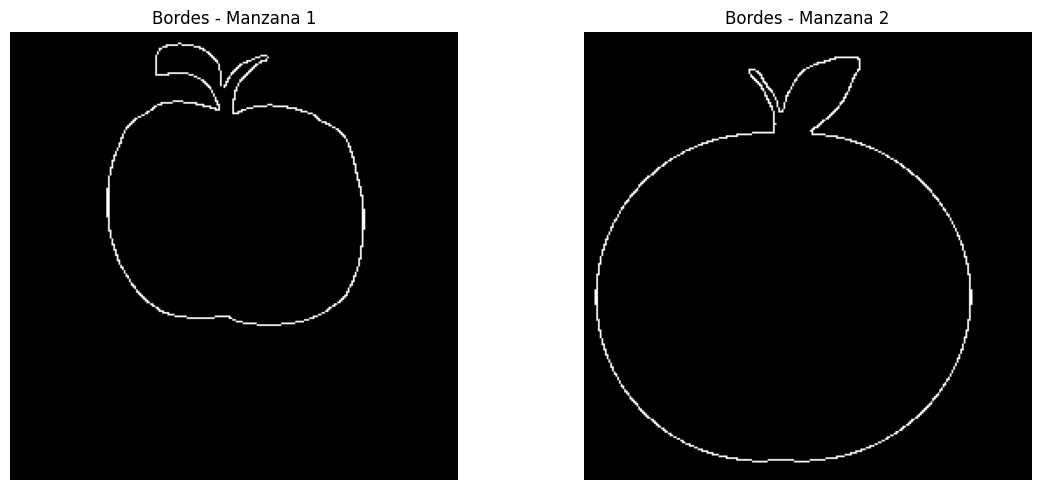

In [ ]:
#Tomamos 2 iamgenes con diferente escala
apple_image_1 = '/content/drive/MyDrive/dataset_shapes_reducido/apple-4.gif'
apple_image_2 = '/content/drive/MyDrive/dataset_shapes_reducido/apple-12.gif'

#Tomamos sus vectores DFC
dfc_vector_1 = process_and_extract_dfc_canny(apple_image_1, 60)
dfc_vector_2 = process_and_extract_dfc_canny(apple_image_2, 60)


#Normalizamos
dfc_vector_1 = dfc_vector_1 / np.linalg.norm(dfc_vector_1)
dfc_vector_2 = dfc_vector_2 / np.linalg.norm(dfc_vector_2)

#Vemos la distnacia euclidena
distancia_euclidiana = np.linalg.norm(dfc_vector_1 - dfc_vector_2)
print(distancia_euclidiana)


#Mostramos imagen
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

img = imread(apple_image_1)
if img.shape[0] == 1:
    img = img[0]
bordes = canny(img, sigma=1.0)
bordes_binzarizado = bordes.astype(np.uint8)

axes[0].imshow(bordes_binzarizado, cmap="gray")
axes[0].set_title("Bordes - Manzana 1")
axes[0].axis('off')

img = imread(apple_image_2)
if img.shape[0] == 1:
    img = img[0]
bordes = canny(img, sigma=1.0)
bordes_binzarizado = bordes.astype(np.uint8)

axes[1].imshow(bordes_binzarizado, cmap="gray")
axes[1].set_title("Bordes - Manzana 2")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Varianza entre clases

0.3470556309071935


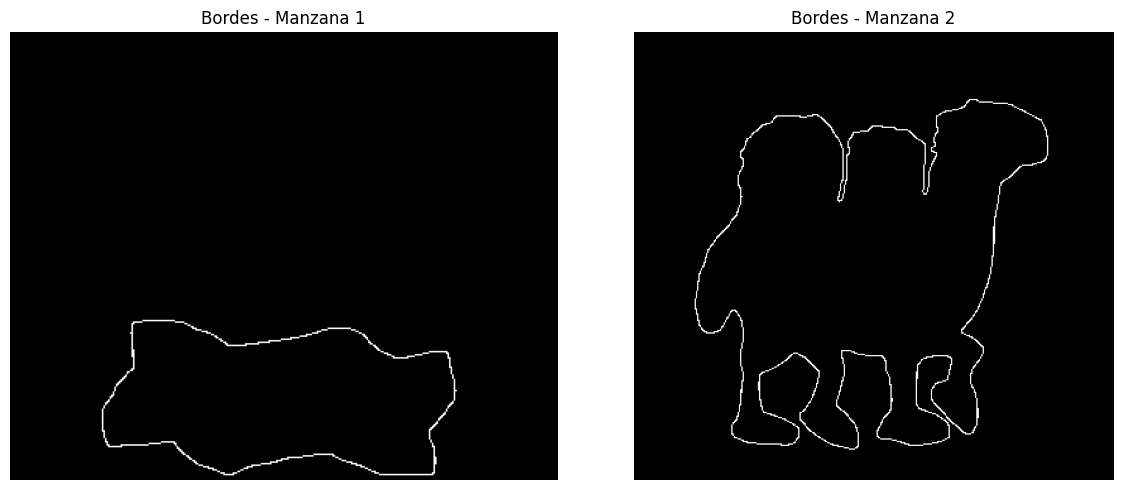

In [ ]:
#Tomamos 2 imagenes que tegan figuras diferentes
brick_image = '/content/drive/MyDrive/dataset_shapes_reducido/brick-17.gif'
camel_image = '/content/drive/MyDrive/dataset_shapes_reducido/camel-9.gif'

#Tomamos sus vectores DFC
dfc_vector1 = process_and_extract_dfc_canny(brick_image, 60)
dfc_vector2 = process_and_extract_dfc_canny(camel_image, 60)

#Normalizamos
dfc_vector1 = dfc_vector1 / np.linalg.norm(dfc_vector1)
dfc_vector2 = dfc_vector2 / np.linalg.norm(dfc_vector2)

#Vemos la distnacia euclidena
distancia_euclidiana = np.linalg.norm(dfc_vector1 - dfc_vector2)
print(distancia_euclidiana)


#Mostramos imagen
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

img = imread(brick_image)
if img.shape[0] == 1:
    img = img[0]
bordes = canny(img, sigma=1.0)
bordes_binzarizado = bordes.astype(np.uint8)

axes[0].imshow(bordes_binzarizado, cmap="gray")
axes[0].set_title("Bordes - Manzana 1")
axes[0].axis('off')

img = imread(camel_image)
if img.shape[0] == 1:
    img = img[0]
bordes = canny(img, sigma=1.0)
bordes_binzarizado = bordes.astype(np.uint8)

axes[1].imshow(bordes_binzarizado, cmap="gray")
axes[1].set_title("Bordes - Manzana 2")
axes[1].axis('off')

plt.tight_layout()
plt.show()